In [181]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
from google.colab import drive
import pickle
from IPython.display import display
from scipy.interpolate import griddata
import matplotlib.cm as cm
import matplotlib
import panel as pn
import math

# Definzione delle costanti
IMG_DIR = '/content/drive/MyDrive/Uni/Magistrale/Sensori/Immagini 3D nuove/' # Cartella contenente le immagini

# Lista delle immagini
img_measure = ['im_1.jpg', 'im_2.jpg', 'im_3.jpg', 'im_4.jpg', 'im_5.jpg',
               'im_6.jpg', 'im_7.jpg', 'im_8.jpg', 'im_9.jpg', 'im_10.jpg',
               'im_11.jpg', 'im_12.jpg', 'im_13.jpg', 'im_14.jpg', 'im_15.jpg',
               'im_16.jpg', 'im_17.jpg', 'im_18.jpg'] # Immagini di test

z_offset = 25 # Offset z della camera

# Definzione della cartella di output nel drive
OUTDIR = '/content/drive/MyDrive/Uni/Magistrale/Sensori/Immagini 3D nuove/out/' # Cartella di output per salvare i risultati della taratura

# File contenente i coefficienti A,B,C del piano
COEFF_FILENAME = 'coefficientiPiano.dump'
# File contenente la matrice m
MATRIX_M_FILENAME = 'matrixM.dump'

# Importazione dei file presenti sulla cartella Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
# Per scaricare componenti necessari per utilizzare panel su colab
!pip install jupyter_bokeh

In [183]:
# Importazione coefficienti A,B,C del piano e ella matrice M
with open(OUTDIR + COEFF_FILENAME, 'rb') as f:
    coeff = pickle.load(f)
with open(OUTDIR + MATRIX_M_FILENAME, 'rb') as f:
    m = pickle.load(f)


A = coeff[0]
B = coeff[1]
C = coeff[2]

In [184]:
# Importazione delle immagini di test e salvataggio su list
img_list_rgb = []
img_list_gray = []

for img_name in img_measure:
    img = cv.imread(IMG_DIR + img_name)
    assert img is not None, f"ERRORE: File {img_name} non trovato!"
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Aggiunta delle immagini alla lista
    img_list_rgb.append(img_rgb)
    img_list_gray.append(img_gray)

In [185]:
# Creazione del selettore per selezionare l'immagine da testare
pn.extension()

selector = pn.widgets.Select(name='Immagine di test', options=img_measure)
selector

Select(name='Immagine di test', options=['im_1.jpg', 'im_2.jpg', ...], value='im_1.jpg')

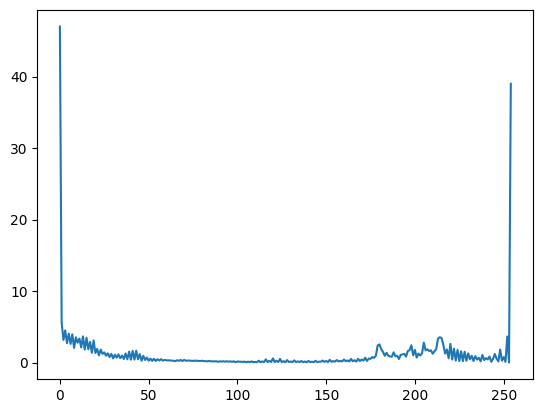

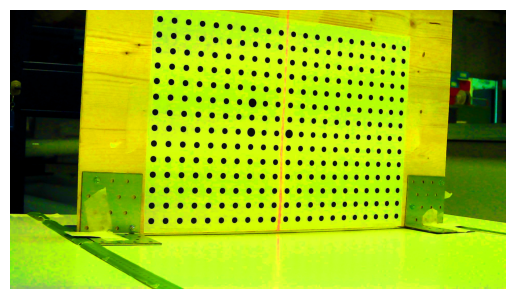

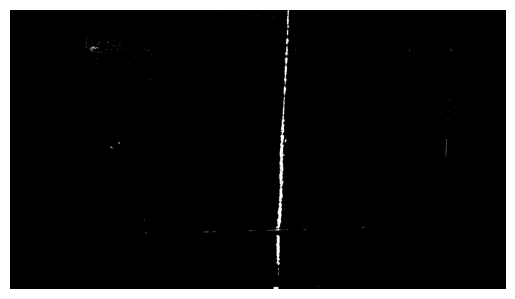

In [186]:
# Elaborazione di un'immagine per determinare la lama di luce
img_test = cv.imread(IMG_DIR + '25.jpg')
img_test = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
#img_test = img_list_rgb[img_measure.index(selector.value)].copy()

image_hls = cv.cvtColor(img_test, cv.COLOR_RGB2HLS)

h, l, s = cv.split(image_hls)

s = cv.multiply(s, 7.1)
l = cv.add(l, -10)
h = cv.add(h, 0)

#s = cv.add(s, 250)
#l = cv.add(l, -120)
#h = cv.add(h, 10)

img_s = cv.merge([h, l, s])
img = cv.cvtColor(img_s, cv.COLOR_HLS2RGB)

h, w = img.shape[:2]
sz = h*w

pdf = np.histogram(img, bins=range(256))[0]/sz*100
plt.plot(pdf)
plt.show()

plt.imshow(img)
plt.axis('off')
plt.show()

temp = img[:,:,0]
h, w = temp.shape
sz = h*w

ret, th = cv.threshold(temp, 254, 255, cv.THRESH_BINARY)
plt.imshow(th, cmap='gray')
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

Numero di punti sulla linea dopo primo processing: 994
Media: 1036.354124748491, Dev. standard: 98.75965861171832
Numero di punti sulla linea dopo l'eliminazione: 857


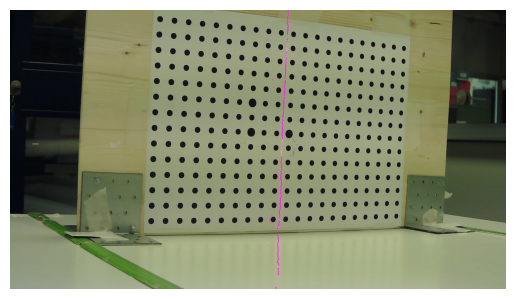

In [187]:
# Rilevamento dei baricentri della lama di luce
# Estrazione del baricentro della linea
h, w = th.shape
line = np.zeros( h ) # Creazione array di zeri
for i in range( h ):
    line[i] = np.mean( np.where( th[i,:] != 0 ) ) # Calcolo della media tra i punti bianchi (==255) di ciascuna riga

    # Plot della linea sull'immagine iniziale
    img_line = img_test.copy()

    laser_line = []

    # Set dei pixel di line nell'immagine rgb, di colore nero
    count = 0
    for i in range(len(line)):
        if not math.isnan(line[i]):
            img_line[i,int(line[i])] = [0,0,0]
            count = count + 1
            laser_line.append([int(line[i]), i])

print(f'Numero di punti sulla linea dopo primo processing: {count}')

# Calcolo media e dev. standard per scartare i punti outliners
laser_line_np = np.array(laser_line)
laser_i = laser_line_np[:,0]
mean_laser_i = np.mean(laser_i)
std_laser_i = np.std(laser_i)
print(f'Media: {mean_laser_i}, Dev. standard: {std_laser_i}')

delta = 0.5

laser_line_adj = []

for point in laser_line:
    if point[0] < mean_laser_i - delta*std_laser_i or point[0] > mean_laser_i + delta*std_laser_i:
        count = count - 1
    else :
      laser_line_adj.append(point)

print(f'Numero di punti sulla linea dopo l\'eliminazione: {count}')

for point in laser_line_adj:
    cv.circle(img_line, point, 1, (255,0,255), -1)

plt.imshow(img_line)
plt.axis('off')
plt.show()

In [188]:
# Ottenuti i baricentro si devono applicare le due equazioni per determinare xsg, ysg, zsg conoscendo i punti i_s, j_s
xyzsg_vec=[]

for point in laser_line_adj:
    i_s = point[0]
    j_s = point[1]

    # Calcolo della matrice A
    A_M = [ [m[0]-m[8]*i_s, m[1]-m[9]*i_s, (m[2]-m[10]*i_s)], [m[4]-m[8]*j_s, m[5]-m[9]*j_s, (m[6]-m[10]*j_s)], [A, B, -1]  ]
    b_M = np.array([[i_s-m[3], j_s-m[7], - C]]).T
    xyzsg_j = np.linalg.solve(A_M,b_M)
    xyzsg_vec.append(xyzsg_j)

print(f"matrice A di questo sistema lineare:")
display(A_M)
print(f"vettore b di questo sistema lineare:")
display(b_M)

print(f"esempi di coordina te xsg,ysg,zsg del barricentro di alcune lame di luce sull'oggetto:")
display(xyzsg_j)
display(xyzsg_vec[0])
display(xyzsg_vec[100])
display(xyzsg_vec[0][1])

print(f"lunghezza vettore xyzsg_vec:")
display(len(xyzsg_vec))

matrice A di questo sistema lineare:


[[2.4504828360617474, 0.12342357428915625, 1.1803260479206026e-08],
 [-0.18894669515268414, -2.8283065957444045, 1.3751495437926803e-13],
 [0.7531210014629192, 0.001475796700646237, -1]]

vettore b di questo sistema lineare:


array([[ 94.63313211],
       [606.58703187],
       [ 31.22641484]])

esempi di coordina te xsg,ysg,zsg del barricentro di alcune lame di luce sull'oggetto:


array([[  49.58723037],
       [-217.78274537],
       [   5.7973667 ]])

array([[ 49.97058481],
       [173.03530554],
       [  6.66284697]])

array([[ 50.37967354],
       [131.78772318],
       [  6.91006724]])

array([173.03530554])

lunghezza vettore xyzsg_vec:


857

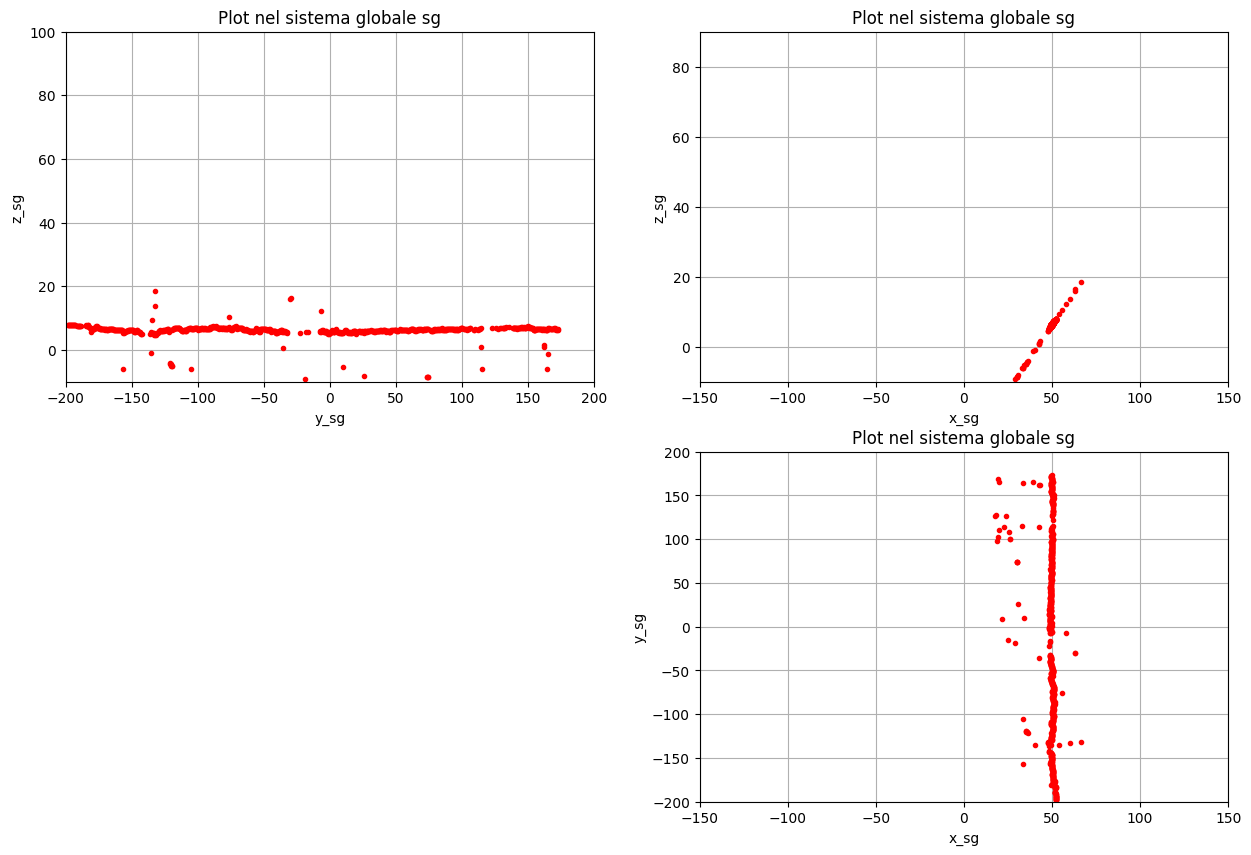

In [189]:
# Rappresentazione grafica
x_sgp=[]
y_sgp=[]
z_sgp=[]
for j in range( len(xyzsg_vec)):
    x_sgp.append(xyzsg_vec[j][0])
    y_sgp.append(xyzsg_vec[j][1])
    z_sgp.append(xyzsg_vec[j][2])

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title("Plot nel sistema globale sg")
plt.plot(y_sgp, z_sgp, '.', color="red")
plt.ylabel('z_sg')
plt.xlabel('y_sg')
plt.xlim([-200, 200])
plt.ylim([-10, 100])
plt.grid()

plt.subplot(222)
plt.title("Plot nel sistema globale sg")
plt.plot(x_sgp, z_sgp, '.', color="red")
plt.ylabel('z_sg')
plt.xlabel('x_sg')
plt.xlim([-150, 150])
plt.ylim([-10, 90])
plt.grid()

plt.subplot(224)
plt.title("Plot nel sistema globale sg")
plt.plot(x_sgp, y_sgp, '.', color="red")
plt.ylabel('y_sg')
plt.xlabel('x_sg')
plt.xlim([-150, 150])
plt.ylim([-200, 200])
plt.grid()


plt.show()